# 作业6：图像拼接
- Author: Wei Jiangnan 2024.9
--------------------------------------------------------------------------------------------------------------------------
#### 1. 实现图像的拼接
- 读取两张图像`img1.jpg`和`img2.jpg`，将两张图像拼接在一起。
- 读取第三张图像`img3.jpg`，将`img3.jpg`继续拼接到`img1`和`img2`的拼接图像上。
--------------------------------------------------------------------------------------------------------------------------
#### 2. 实现长方形广告牌的透视变换
- 读取一张图像`billboard.jpg`，已知图像中的广告牌是一个长方形，将广告牌的图像替换为`yuanshen.jpg`。
--------------------------------------------------------------------------------------------------------------------------


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

### 1 图像拼接 （70）
- 读取两张图像`img1.jpg`和`img2.jpg`，将两张图像拼接在一起。
- 读取第三张图像`img3.jpg`，将`img3.jpg`继续拼接到`img1`和`img2`的拼接图像上。

#### 1-1 计算单应矩阵（25）
- 实现函数`get_H(img1, img2)`，输入两张图像，输出两张图像的单应性矩阵`H`。
- 为了计算单应性矩阵，需要先找到两张图像的特征点，然后计算单应性矩阵，建议使用`SIFT`特征点检测算法。


In [12]:
def get_H(img1, img2):
    '''
    Args:
        img1: image 1
        img2: image 2
    Returns:
        H: homography matrix
    '''
    gray1=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    gray2=cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    #初始化SIFT特征检测器，检测图像中的关键点和描述符
    sift=cv2.SIFT_create()
    #检测特征点和计算描述符
    kp1,des1=sift.detectAndCompute(gray1,None)
    kp2,des2=sift.detectAndCompute(gray2,None)
    #FLANN特征匹配器，使用KD算法，构建5棵KD树，指定搜索次数
    FLANN_INDEX_KDTREE=1
    index_params=dict(algorithm=FLANN_INDEX_KDTREE,trees=5)
    search_params=dict(checks=50)
    flann=cv2.FlannBasedMatcher(index_params,search_params)
    #进行特征匹配，找到两个最近邻匹配点
    matches=flann.knnMatch(des1,des2,k=2)
    #存储较好的匹配
    good_matches=[]
    for m,n in matches:
        if m.distance<0.7*n.distance:
            good_matches.append(m)
    #匹配点的坐标提取
    src_pts=np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts=np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    #计算单应矩阵
    H, mask=cv2.findHomography(src_pts,dst_pts,cv2.RANSAC,5.0)

    return H

#### 1-2  拼接图像（45）
- 实现函数`img_stitching(img1, img2, H)`，将两张图像拼接在一起。
- **提示**：可以使用`cv2.warpPerspective`函数实现单应性变换。
- **注意**：采用`cv2.findHomography(img1_pts, img1_pts, cv2.RANSAC, 5.0)`得到的单应矩阵为img1到img2的单应矩阵，因此在拼接时，需要将img1变换到img2的坐标系下，即`cv2.warpPerspective(img1, H, output_shape))`。

In [13]:
def stitch(img1, img2, H):
    '''
    Args:
        img1: image 1
        img2: image 2
        H: homography matrix
    Returns:
        result: stitched image
    '''
    #获取图片的尺寸
    h1,w1=img1.shape[:2]
    h2,w2=img2.shape[:2]

    #图片1的四个角点坐标，转换成相应格式
    jiaodian=np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    jiaodian_trans=cv2.perspectiveTransform(jiaodian,H)#图像1四个角点变换后的位置

    #得到图片的边界
    xmin=min(np.min(jiaodian_trans[:,:,0]),0)
    xmax=max(np.max(jiaodian_trans[:,:,0]),w2)
    ymin=min(np.min(jiaodian_trans[:,:,1]),0)
    ymax=max(np.max(jiaodian_trans[:,:,1]),h2)

    #根据图像边界得到需要移动的量
    offsetx=-int(xmin) if xmin<0 else 0
    offsety=-int(ymin) if ymin<0 else 0

    #图像输出尺寸
    output=((int(xmax-xmin)),int(ymax-ymin))

    #平移矩阵
    T=np.array([
        [1,0,offsetx],
        [0,1,offsety],
        [0,0,1]
    ])
    H_ad=T@H#两重变换，先旋转再平移得到新的单应矩阵
    #透视变换
    result=cv2.warpPerspective(img1,H_ad,output)
    #将图片2的内容拼接上
    result[offsety:offsety+h2,offsetx:offsetx+w2]=img2

    return result

#### 1-3 拼接两张图像(20)
- 读取两张图像`img1.jpg`和`img2.jpg`，将两张图像拼接在一起。
- `无需改动代码，直接运行即可。`

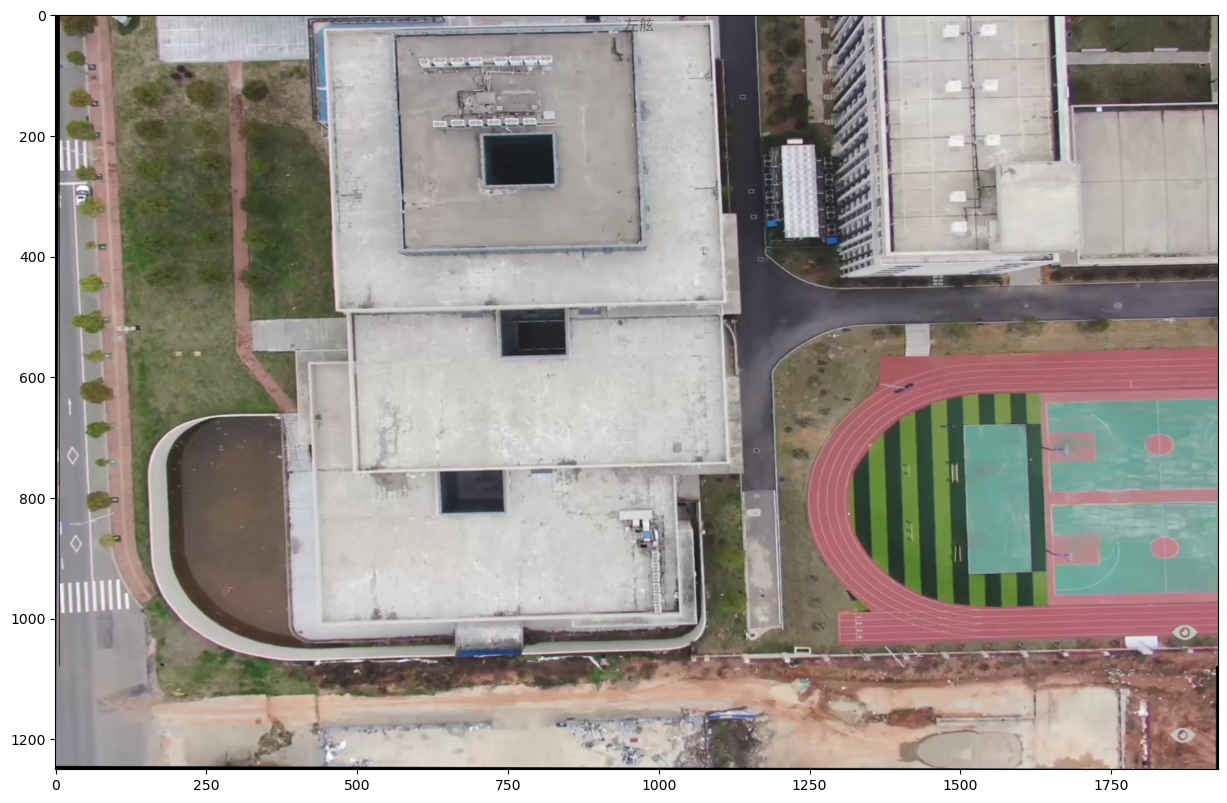

In [14]:
img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')
plt.figure(figsize=(15, 15))
H = get_H(img1, img2)
result = stitch(img1, img2, H)
B, G, R = cv2.split(result)
result_show = cv2.merge([R, G, B])
plt.imshow(result_show)

#### 1-4 拼接三张图像(25)
- 读取第三张图像`img3.jpg`，将`img3.jpg`继续拼接到`img1`和`img2`的拼接图像上。
- `无需改动代码，直接运行即可。`

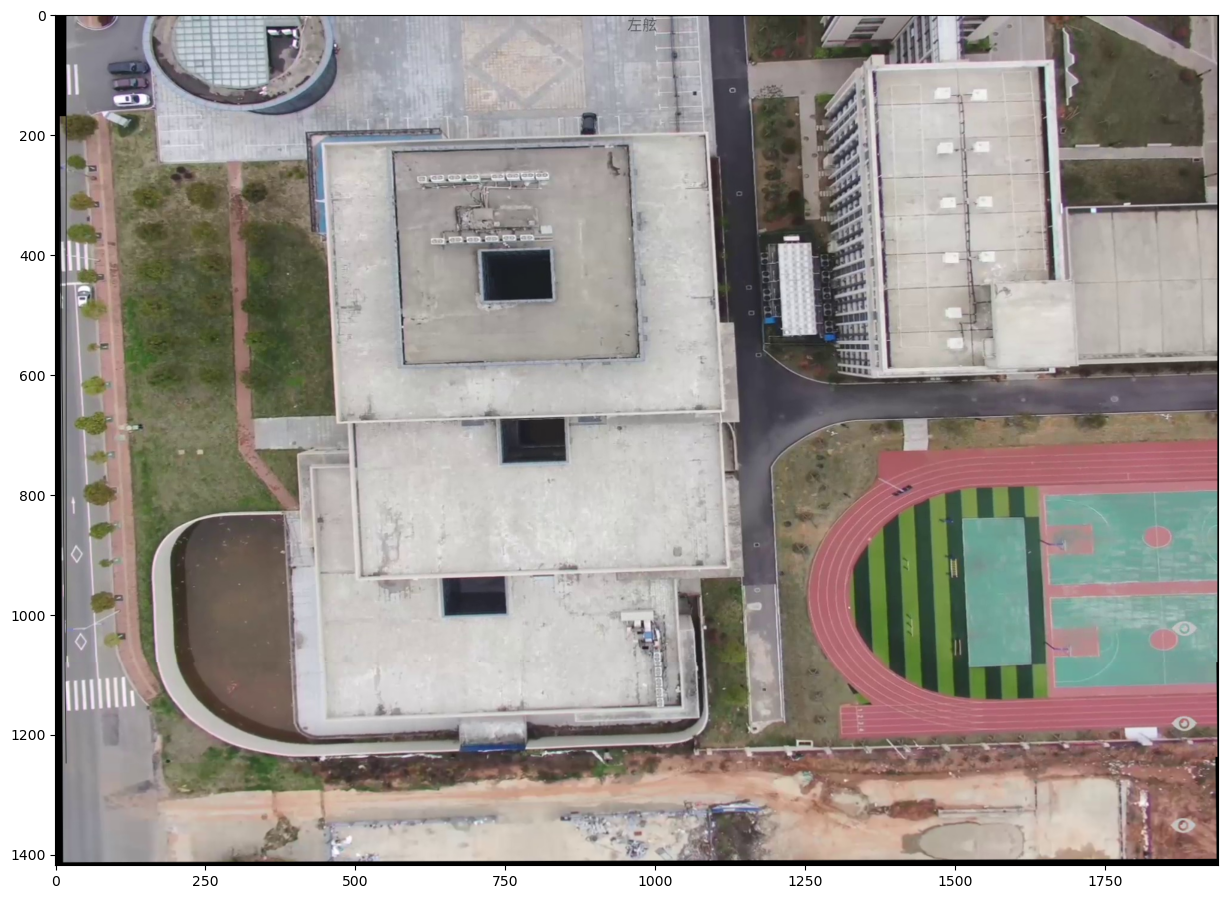

In [15]:
img3 = cv2.imread('img3.jpg')
plt.figure(figsize=(15, 15))
H = get_H(result, img3)
result = stitch(result, img3, H)
B, G, R = cv2.split(result)
result = cv2.merge([R, G, B])
plt.imshow(result)

### 2 长方形广告牌的单应变换 （30）
- 读取一张图像`billboard.jpg`，已知图像中的广告牌是一个长方形，将广告牌的图像替换为`yuanshen.jpg`。
- 广告牌左上，右上，右下，左下的四个顶点坐标为`[[2068, 209], [3123, 239], [3129, 632], [2075, 635]]`。
- 函数原型为`yuanshenqidong(billboard, yuanshen, pts)`，其中`pts`为广告牌的四个顶点坐标。

In [18]:
def yuanshenqidong(billboard, yuanshen, pts):
    '''
    Args:
        billboard: billboard image
        yuanshen: yuanshen image
        pts: coordinates of the four corners of the billboard in the yuanshen image
    Returns:    
        result: stitched image
    '''
    #得到原图片尺寸
    h,w=yuanshen.shape[:2]
    #原神的四个角点和广告牌的四个角点，得到单应矩阵
    pts1=np.float32([[0,0],[w-1,0],[w-1,h-1],[0,h-1]])
    pts2=np.float32(pts)
    H=cv2.findHomography(pts1,pts2)[0]
    #对原神图片进行透视变换
    yuanshen_warped=cv2.warpPerspective(yuanshen,H,(billboard.shape[1],billboard.shape[0]))
    #创建一个与广告牌图片相等的掩码，再掩码上使用白色填充广告牌区域
    mask=np.zeros_like(billboard)
    pts2=pts2.astype(np.int32)
    cv2.fillPoly(mask,[pts2],(255,255,255))
    #原图中的广告牌区域设置为黑色
    billboard_mask=cv2.bitwise_and(billboard,cv2.bitwise_not(mask))
    result=cv2.add(billboard_mask,yuanshen_warped)
    return result



#### 2-1 原神启动！
- `无需改动代码，直接运行即可。`

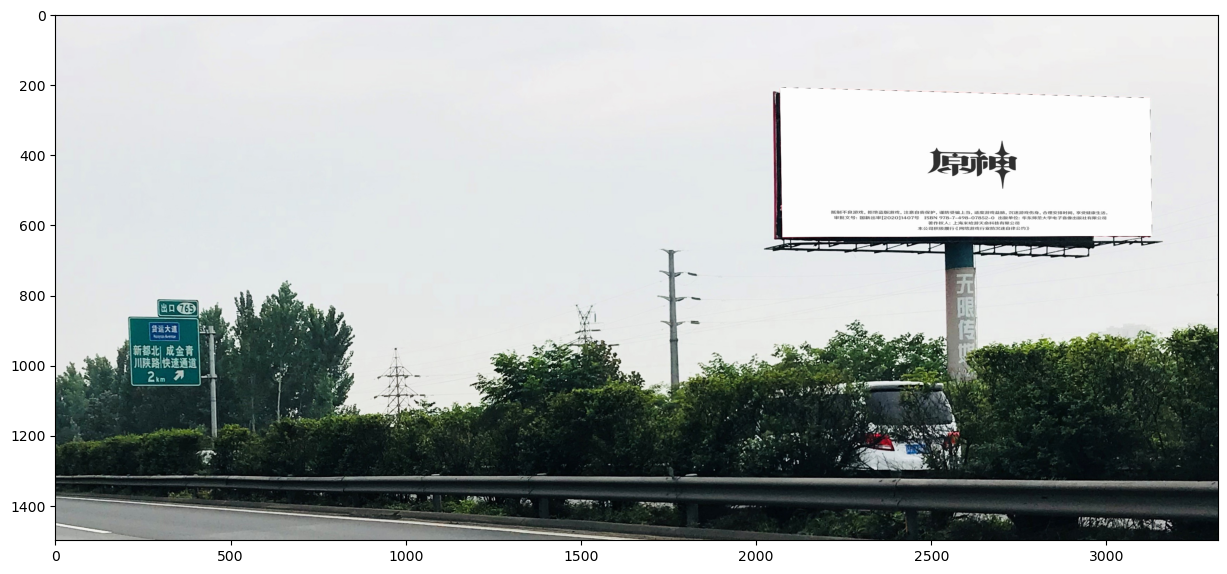

In [19]:
yuanshen=cv2.imread('yuanshen.jpg')
billboard=cv2.imread('billboard.jpg')
plt.figure(figsize=(15, 15))
billboard_corners=[[2068, 209], [3123, 239], [3129, 632], [2075, 635]]
result=yuanshenqidong(billboard, yuanshen,billboard_corners)
#交换BGR通道使得plt可以正确显示图片
B, G, R = cv2.split(result)
result = cv2.merge([R, G, B])
plt.imshow(result)


##### 实验收获与感悟
- 请在这里给出你对本次实验的收获与感悟，可以是对本次实验的建议，也可以是对本次实验的心得体会。